In [ ]:
import numpy as np 
import pandas as pd

#We are using keras as our base package to build our binary classifier. 
import keras
from keras.layers import *
from keras.models import *
from keras.preprocessing import image
from keras.utils.vis_utils import plot_model
from keras.callbacks import  EarlyStopping

import os
import gc
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tqdm import tqdm
import cv2

from keras.layers import Activation
from keras.utils.generic_utils import get_custom_objects

In [ ]:
trainPATH = '/content/drive/MyDrive/Train'
valPATH = '/content/drive/MyDrive/Validation'

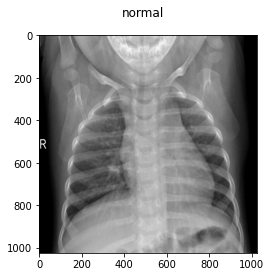

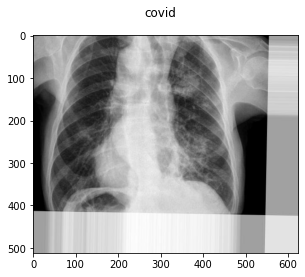

In [ ]:
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

normal_images = []
for img_path in glob.glob(trainPATH + '/Normal/*')[:2]:
    normal_images.append(mpimg.imread(img_path))

fig = plt.figure()
fig.suptitle('normal')
plt.imshow(normal_images[0], cmap='gray') 

covid_images = []
for img_path in glob.glob(valPATH + '/Corona/*')[:2]:
    covid_images.append(mpimg.imread(img_path))

fig = plt.figure()
fig.suptitle('covid')
plt.imshow(covid_images[0], cmap='gray') 

In [ ]:
def img_gen(train_path_variable, val_path_variable):
  train_preprocess = keras.preprocessing.image.ImageDataGenerator(
                                        rescale = 1./255,
                                        zoom_range = 0.2,
                                        shear_range = 0.2,
                                        horizontal_flip = True
                                    )

  train = train_preprocess.flow_from_directory(
                                        train_path_variable,
                                        target_size = (224, 224),
                                        batch_size = 16,
                                        class_mode = 'binary'
                                    )
  validation_preprocess = keras.preprocessing.image.ImageDataGenerator(
                                        rescale=1./255
                                    )

  val = validation_preprocess.flow_from_directory(
                                        val_path_variable,
                                        target_size = (224, 224),
                                        batch_size = 16,
                                        class_mode = 'binary'
  )

  return train, val

In [ ]:
train, val = img_gen(trainPATH, valPATH)

Found 5136 images belonging to 2 classes.
Found 1847 images belonging to 2 classes.


In [ ]:
train.class_indices

{'Corona': 0, 'Normal': 1}

In [ ]:
model = Sequential()
model.add(Conv2D(32, kernel_size = (3, 3), activation = 'relu', input_shape = (224, 224, 3)))
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience = 1)

In [ ]:
history = model.fit(
                                train,
                                epochs = 2,
                                validation_data = val, 
                                callbacks = [early_stop],
                                batch_size = 4096
                    )

Epoch 1/2
321/321 [==============================] - 198s 618ms/step - loss: 0.3073 - accuracy: 0.8660 - val_loss: 0.1808 - val_accuracy: 0.9496
Epoch 2/2
321/321 [==============================] - 198s 616ms/step - loss: 0.2975 - accuracy: 0.8688 - val_loss: 0.0939 - val_accuracy: 0.9713


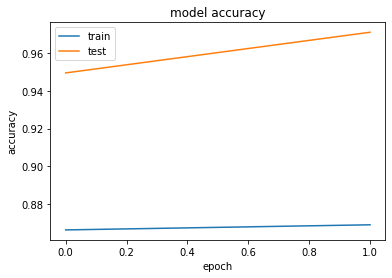

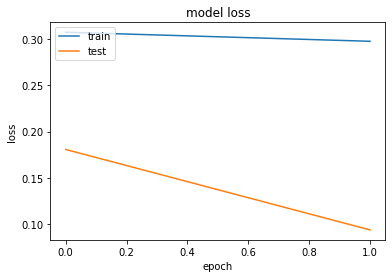

In [ ]:
# metric and loss graph

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#picking up images from validation set of covid xrays

from tqdm import tqdm
import cv2
images = []
path = '/content/drive/MyDrive/Validation/Corona'
for filename in tqdm(os.listdir(path)):
    file_path = os.path.join(path, filename)
    image0 = plt.imread(file_path)
    image0 = cv2.resize(image0, (224, 224))
    image0 = cv2.cvtColor(image0, cv2.COLOR_BGR2RGB)
    images.append(image0)

100%|██████████| 925/925 [00:21<00:00, 42.12it/s] 


In [ ]:
# picking up images from validation set of normal xrays
images1 = []
path = '/content/drive/MyDrive/Validation/Normal'
for filename in tqdm(os.listdir(path)):
    file_path = os.path.join(path, filename)
    image1 = plt.imread(file_path)
    image1 = cv2.resize(image1, (224, 224))
    image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
    images.append(image1)

100%|██████████| 922/922 [00:13<00:00, 69.98it/s]


In [ ]:
# prediction and resizing the preds array

images = np.array(images) / 255.0

preds = model.predict(images)
preds.resize(1, len(preds))
predIdxs = np.round(preds[0])

labels = val.labels

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print("[INFO] evaluating network...")
# show a nicely formatted classification report
print(classification_report(labels, predIdxs))

# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(labels, predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))


[INFO] evaluating network...
              precision    recall  f1-score   support

           0       1.00      0.95      0.97       925
           1       0.95      1.00      0.97       922

    accuracy                           0.97      1847
   macro avg       0.97      0.97      0.97      1847
weighted avg       0.97      0.97      0.97      1847

[[880  45]
 [  4 918]]
acc: 0.9735
sensitivity: 0.9514
specificity: 0.9957


In [ ]:
exp_series = pd.Series(labels)
pred_series = pd.Series(predIdxs)
pd.crosstab(exp_series, pred_series, rownames=['Actual'], colnames=['Predicted'],margins=True)

Predicted,0.0,1.0,All
Actual,,,
0,880,45,925
1,4,918,922
All,884,963,1847


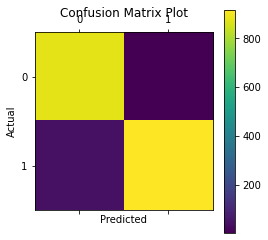

In [ ]:
cf = confusion_matrix(predIdxs, labels)

plt.matshow(cf)
plt.title('Confusion Matrix Plot')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show();

In [ ]:
model.save('final_model_covid_detection.hdf5')